In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
!curl -O https://ifs-cdn.ru/d/eyJ0IjoiMjAyMC0xMS0yN1QxMDozNDo1Ny45NjUxODY1WiIsInRtIjoxNSwiYmQiOjEsImZkIjo2Mjc3Mzc0LCJyZiI6bnVsbCwic2wiOjAsImZuIjoiRnVsbERhdGFzZXQuemlwIiwiciI6Imh0dHBzOi8vbXktZmlsZXMuc3Uvbjgyc3h1IiwibCI6bnVsbH0,.B5680190F89999D7B75A3D64AFC84E0F./FullDataset.zip
!unzip -q FullDataset.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 97 4061M   97 3948M    0     0  1148k      0  1:00:19  0:58:39  0:01:40 1107k 1144k      0  1:00:34  0:01:46  0:58:48 1159k 0  1:00:19  0:12:41  0:47:38  958k0k  0:16:34  0:43:42 1160k19  0:18:41  0:41:38 1006k0  1:00:20  0:22:45  0:37:35  918k  0:33:23 1153k  0:26:59  0:33:20 1164k22  0:30:57 1163k4  0:29:43 1163k:00:18  0:31:53  0:28:25 1163k   0     0  1149k      0  1:00:18  0:34:34  0:25:44 1161k:24:01 1163k148k      0  1:00:20  0:41:44  0:18:36 1149k0:43:15  0:17:05 1163k:00:19  0:48:48  0:11:31 1168k  0:51:13  0:09:06 1162k19  0:54:30  0:05:49 1173k

In [ ]:
num_skipped = 0
for folder_name in ('Ancient', 'Art Nouveau (Modern)', 'Baroque', 'Bauhaus', 'Byzantine', 'Colonial', 'Deconstructivism', 'Georgian', 'Gothic', 'Greek Revival', 'International style', 'Palladian (Classicism)', 'Romanesque', 'Russian Revival', 'Russian Wooden'):
    folder_path = os.path.join("FullDataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

In [2]:
batch_size = 32
img_height = 256
img_width = 256
image_size = (img_height, img_width)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "FullDataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "FullDataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

class_names = train_ds.class_names
print(class_names)

Found 9022 files belonging to 15 classes.
Using 7218 files for training.
Found 9022 files belonging to 15 classes.
Using 1804 files for validation.
['Ancient', 'Art Nouveau (Modern)', 'Baroque', 'Bauhaus', 'Byzantine', 'Colonial', 'Deconstructivism', 'Georgian', 'Gothic', 'Greek Revival', 'International style', 'Palladian (Classicism)', 'Romanesque', 'Russian Revival', 'Russian Wooden']


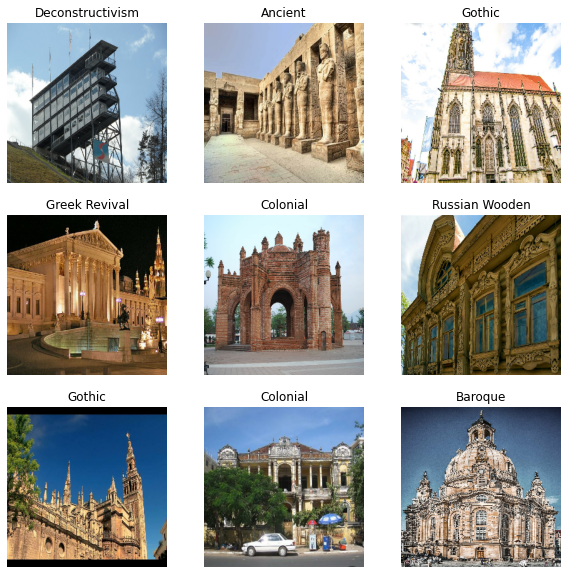

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [4]:
from random import seed
from random import randint

@ tf.function
def random_invert_img(x, p, dynamic=True):
    if  tf.random.uniform([]) < p:
        x = (255-x)
    else:
        x
    return x

seed(1)

@ tf.function
def random_brightness_img(x, p, dynamic=True):
    if  tf.random.uniform([]) < p:
        value = randint(50, 100)
        x = x * (value / 100)
    else:
        x
    return x

@ tf.function
def random_contrast_img(x, p, dynamic=True):
    if  tf.random.uniform([]) < p:
        x = x * (x / 255) 
    else:
        x
    return x

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomZoom(0.5),
        layers.experimental.preprocessing.RandomRotation(0.05),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.Lambda(lambda x: random_invert_img(x, 0.1)),
        layers.Lambda(lambda x: random_contrast_img(x, 0.5)),
        layers.Lambda(lambda x: random_brightness_img(x, 0.5))
    ])

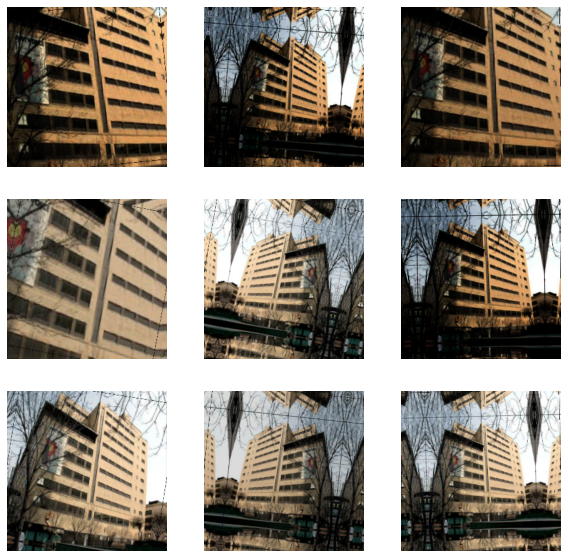

In [5]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

checkpoint = ModelCheckpoint(filepath='save/checkpoint-{epoch:02d}-{val_accuracy:.2f}.hdf5', monitor='val_accuracy', save_best_only=True)

In [7]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    
    x = layers.experimental.preprocessing.Rescaling(1./255)(x)
    
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.05)(x)
    x = layers.Conv2D(48, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.05)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.05)(x)
    
    previous_block_activation = x

    for size in [96, 128, 192, 256, 384, 512, 768]:
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
           previous_block_activation
        )
        
        x = layers.add([x, residual])
        previous_block_activation = x
        x = layers.Dropout(0.05)(x)

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.05)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(num_classes)(x)

    outputs = layers.Dense(256, activation='relu')(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=15)
keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint]
)

Epoch 1/30
226/226 [==============================] - 221s 980ms/step - loss: 3.5815 - accuracy: 0.1671 - val_loss: 4.1337 - val_accuracy: 0.0665
Epoch 2/30
226/226 [==============================] - 220s 972ms/step - loss: 3.0197 - accuracy: 0.2310 - val_loss: 3.1789 - val_accuracy: 0.2034
Epoch 3/30
226/226 [==============================] - 220s 975ms/step - loss: 2.8044 - accuracy: 0.2909 - val_loss: 2.9629 - val_accuracy: 0.2899
Epoch 4/30
226/226 [==============================] - 221s 976ms/step - loss: 2.6631 - accuracy: 0.3272 - val_loss: 4.3981 - val_accuracy: 0.1663
Epoch 5/30
226/226 [==============================] - 219s 970ms/step - loss: 2.5484 - accuracy: 0.3698 - val_loss: 2.8800 - val_accuracy: 0.3176
Epoch 6/30
226/226 [==============================] - 220s 972ms/step - loss: 2.4234 - accuracy: 0.3957 - val_loss: 2.9307 - val_accuracy: 0.2932
Epoch 7/30
226/226 [==============================] - 220s 972ms/step - loss: 1.9003 - accuracy: 0.4255 - val_loss: 1.9621 -

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
for i in range(0, 600):
    try:
        f = keras.preprocessing.image.load_img("FullDataset/Baroque/2("+str(i)+").jpg")
        f.close()
    except FileNotFoundError:
        continue
    img = keras.preprocessing.image.load_img(
        "FullDataset/Baroque/2("+str(i)+").jpg", target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        str(i)+" This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )